# **CONFIG**

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torchvision
from torchvision import transforms , models
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vit_b_16
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import cv2
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
IMG_SIZE=224
BATCH_SIZE=8
NUM_CLASSES=9
EPOCH=100
LR=1e-4
PARENT_DIR="/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/"
TRAIN_DIR="/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
TEST_DIR="/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

# **DATASET**

In [2]:

class SkinImagesDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img_path=os.path.join(self.df["Paths"][idx])
        label=int(self.df["Labels"][idx])
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image)
        return image,label

        

# **TRANSFORMS**

In [3]:
# Use ImageNet normalization stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transforms = val_transforms  

# **MODEL**

In [4]:
def getmodel():
    model = vit_b_16(weights='IMAGENET1K_V1')
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, NUM_CLASSES)
    return model

In [5]:
temp=getmodel()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 232MB/s]


# **TRAINING**

In [6]:
def train_one_epoch(model,dataloader,optimizer,criterion,device):
    model.train()
    total_loss,correct=0,0
    loop=tqdm(dataloader, desc="Training")
    for images,labels in loop:
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        correct+=(outputs.argmax(1)==labels).sum().item()
        loop.set_postfix(loss=total_loss / (loop.n + 1), accuracy=correct / ((loop.n + 1) * dataloader.batch_size))

    avg_loss = total_loss / len(dataloader)
    train_acc = correct / len(dataloader.dataset)
    return avg_loss, train_acc
def validation(model,dataloader, optimizer,criterion,device):
    model.eval()
    total_loss,correct=0,0
    loop = tqdm(dataloader,desc='Validation')
    with torch.no_grad():
        for images,labels in loop:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            total_loss+=loss
            correct+=(outputs.argmax(1)==labels).sum().item()
    loop.set_postfix(loss=total_loss / (loop.n + 1), accuracy=correct / ((loop.n + 1) * dataloader.batch_size))
    
    avg_loss = total_loss / len(dataloader)
    val_acc = correct / len(dataloader.dataset)
    return avg_loss, val_acc
        
        

# **TRAINING LOOP**

In [7]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
all_classes=sorted(os.listdir("/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train"))
le.fit(all_classes)
print(list(le.classes_))
labels=le.transform(all_classes)

df=pd.DataFrame(columns=['Paths',"Labels"])

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:


def make_dataframe(test=False):
    DIR=TEST_DIR
    if test==False:
        DIR=TRAIN_DIR
        
    all_paths=[]
    all_labels=[]
    for i in labels:
        class_path=os.path.join(DIR,all_classes[i])
    
        all_imgs=os.listdir(class_path)
        for j in all_imgs:
            all_paths.append(os.path.join(class_path,j))
            all_labels.append(i)

    df = pd.DataFrame({'Paths': all_paths, 'Labels': all_labels})
    return df
all_df=make_dataframe(test=False)
test_df=make_dataframe(test=True)

In [9]:
train_df,val_df=train_df, val_df = train_test_split(
    all_df, 
    test_size=0.2, 
    stratify=all_df['Labels'],
    random_state=42
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [10]:
train_dataset=SkinImagesDataset(train_df,train_transforms)
val_dataset=SkinImagesDataset(val_df,val_transforms)
test_dataset=SkinImagesDataset(test_df,test_transforms)

train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=1,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=True)

device=torch.device("cuda" if torch.cuda.is_available else 'cpu')
model=getmodel().to(device)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_df['Labels']), 
    y=train_df['Labels']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = getmodel().to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.heads.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
best_acc=0
early_stopping=0
for epoch in tqdm(range(EPOCH),desc='EPOCH'):
    if epoch == 10:
        for param in model.encoder.layers[-4:].parameters():
            param.requires_grad = True
    train_loss,train_acc=train_one_epoch(model,train_loader,optimizer,criterion,device)
    val_loss, val_acc = validation(model, val_loader,optimizer, criterion, device)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val_loss={val_loss:.4f}")
    scheduler.step(val_acc)
    
    if val_acc>best_acc:
        torch.save(model.state_dict(),"best_model.pth")
        best_acc=val_acc
        early_stopping=0
        print("Accuracy Improved , Best Model Saved!")
    
    elif early_stopping==10:
        print("Early Stopping Triggered!")
        break
    else:
        early_stopping+=1
        print("Accuracy not improved")
 

EPOCH:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 1: Train Acc=0.2116, Train Loss=2.0941, Val Acc=0.3571, Val_loss=1.9020
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 2: Train Acc=0.4076, Train Loss=1.8524, Val Acc=0.4353, Val_loss=1.7447
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 3: Train Acc=0.4551, Train Loss=1.6824, Val Acc=0.4643, Val_loss=1.6372
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 4: Train Acc=0.4947, Train Loss=1.5838, Val Acc=0.5402, Val_loss=1.5260
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 5: Train Acc=0.5181, Train Loss=1.4933, Val Acc=0.5112, Val_loss=1.4850
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 6: Train Acc=0.5232, Train Loss=1.4317, Val Acc=0.5446, Val_loss=1.4267
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 7: Train Acc=0.5589, Train Loss=1.3962, Val Acc=0.5357, Val_loss=1.3943
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 8: Train Acc=0.5656, Train Loss=1.3479, Val Acc=0.5312, Val_loss=1.3884
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 9: Train Acc=0.5550, Train Loss=1.3249, Val Acc=0.5580, Val_loss=1.3394
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.5639, Train Loss=1.2728, Val Acc=0.5625, Val_loss=1.2966
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.5293, Train Loss=1.2655, Val Acc=0.5938, Val_loss=1.0926
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.6354, Train Loss=0.9047, Val Acc=0.6228, Val_loss=0.9228
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.7136, Train Loss=0.6875, Val Acc=0.6049, Val_loss=1.0679
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.7554, Train Loss=0.5881, Val Acc=0.6741, Val_loss=0.8532
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.7845, Train Loss=0.4921, Val Acc=0.6362, Val_loss=0.9963
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.8264, Train Loss=0.4303, Val Acc=0.6295, Val_loss=1.0863
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.8442, Train Loss=0.3481, Val Acc=0.6183, Val_loss=1.1662
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.8917, Train Loss=0.2310, Val Acc=0.6629, Val_loss=0.9536
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9129, Train Loss=0.1936, Val Acc=0.7076, Val_loss=0.9400
Accuracy Improved , Best Model Saved!


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9202, Train Loss=0.1914, Val Acc=0.7031, Val_loss=0.9170
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9202, Train Loss=0.1863, Val Acc=0.6763, Val_loss=1.0516
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9168, Train Loss=0.1847, Val Acc=0.6942, Val_loss=0.9777
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9347, Train Loss=0.1374, Val Acc=0.6920, Val_loss=1.0622
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9408, Train Loss=0.1308, Val Acc=0.6942, Val_loss=1.1085
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 25: Train Acc=0.9408, Train Loss=0.1269, Val Acc=0.6763, Val_loss=1.1438
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9464, Train Loss=0.1095, Val Acc=0.6942, Val_loss=1.1389
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 27: Train Acc=0.9458, Train Loss=0.1092, Val Acc=0.6696, Val_loss=1.1634
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9481, Train Loss=0.1025, Val Acc=0.6830, Val_loss=1.2045
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 29: Train Acc=0.9481, Train Loss=0.0996, Val Acc=0.6853, Val_loss=1.2169
Accuracy not improved


Training:   0%|          | 0/224 [00:00<?, ?it/s]

Validation:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 30: Train Acc=0.9453, Train Loss=0.1061, Val Acc=0.6875, Val_loss=1.2421
Early Stopping Triggered!


In [13]:
print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}, Val_loss={val_loss:.4f}")


Epoch 30: Train Acc=0.9453, Train Loss=0.1061, Val Acc=0.6875, Val_loss=1.2421


# **TESTING**

Testing:   0%|          | 0/118 [00:00<?, ?it/s]

Accuracy: 0.6949

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        16
           1       0.79      0.94      0.86        16
           2       0.91      0.62      0.74        16
           3       0.50      0.62      0.56        16
           4       0.56      0.94      0.70        16
           5       0.80      0.75      0.77        16
           6       0.00      0.00      0.00         3
           7       0.82      0.56      0.67        16
           8       1.00      1.00      1.00         3

    accuracy                           0.69       118
   macro avg       0.67      0.66      0.65       118
weighted avg       0.71      0.69      0.68       118



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


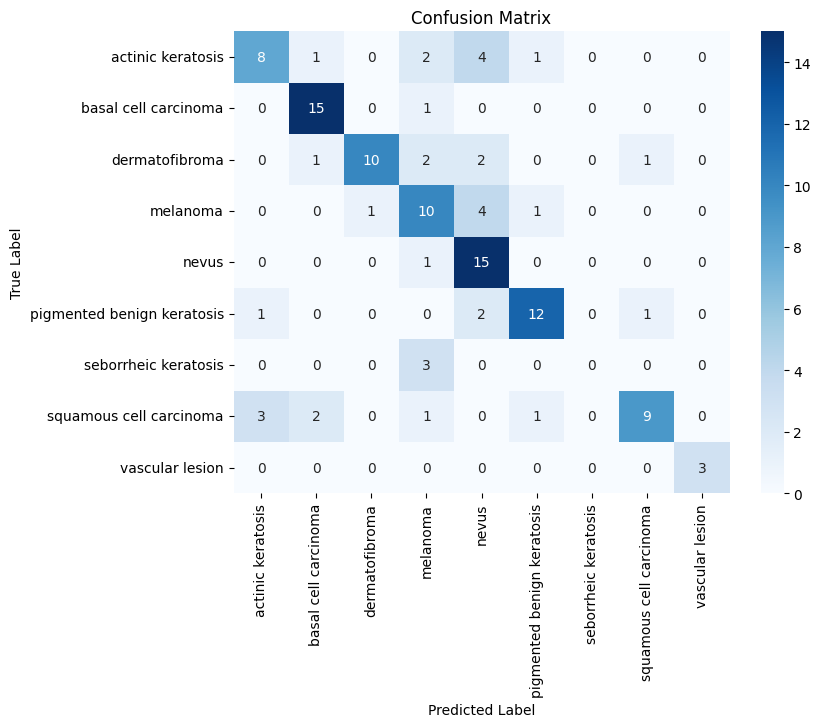

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)
all_preds, all_labels = [], []

loop=tqdm(test_loader,desc='Testing')
with torch.no_grad():
    for images, labels in loop:
        images=images.to(device)
        
        outputs=model(images)
        preds=outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm,all_classes)     
